### Introduction

#### Dataset
The dataset consists of images and their RGB segmented image masks.

Classes in the dataset
1. Background: Black
2. Guns and Knifes: Red
3. Cardboard and Plastic Boxes: Green

#### Task
The goal is to perform Semantic Segmentation using Pytorch.

#### Steps
1. Convert RGB segmented images Mask to class mask and store it in a directory.
2. Create Pytorch dataset class for training, validation and test dataset. Use dataloader for training and validation.
3. Download Pre-trained U-Net model for Semantic Segmentation.
4. Define metrics - mean Intersection Over Union (mIOU) and pixel accuracy.
5. Write the training method. Plot training metrics. Save the model.
6. Use the model for predictions

In [1]:
import os
import time
import cv2
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from tqdm.notebook import tqdm


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torch.nn.functional as F

import albumentations as A

In [2]:
images_path = '../data/images/'
seg_masks_path = '../data/masks/'
class_masks_path = '../data/class_masks/'

images = [img for img in os.listdir(images_path)]
seg_masks = [seg_mask for seg_mask in os.listdir(seg_masks_path)]

print(f'Number of Images: {len(images)}')
print(f'Number of RGB Segmentation Masks: {len(seg_masks):>4}')

Number of Images: 743
Number of RGB Segmentation Masks:  890


The number of masks and images are not equal. So, we will find the respective pairs and discard the rest. After that we will create the class mask from RGB segmented mask.

In [3]:
common_filenames = list(set(images).intersection(seg_masks))

##### Creating Class Mask from RGB Segmented Mask

In [4]:
def segmentation_mask_to_class_mask(input_dir, output_dir, index):
    '''
    Creates class mask from RGB segmented mask from dataset.
    
    input_dir: path of RGB segmented mask
    output_dir: path to store class mask
    index: names of the files for conversion
    '''
    # Create directory for storing class masks
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for file in index:
        seg_path = os.path.join(input_dir, file)
        seg_msk = np.array(Image.open(seg_path))
        
        # Create empty class mask
        class_msk = np.zeros((seg_msk.shape[0],seg_msk.shape[1])).astype(int)
        
        # Assign Red values to class 1, Green values to class 2, Black is class 0
        class_msk[seg_msk[:,:,0]==255]=1
        class_msk[seg_msk[:,:,1]==255]=2
        #print(np.unique(class_msk))
        
        # Save the file
        output_filename = output_dir+file
        cv2.imwrite(output_filename,class_msk)
        #print(f'Writing file {output_filename}')
    
    print('Completed')
    
def class_mask_to_segmentation_mask(mask):
    '''
    Creates RGB segmented mask from class mask
    '''
    # Create empty rgb segmented mask
    rgb_mask = np.zeros((mask.shape[0],mask.shape[1],3)).astype(int)
    rgb_mask[mask==1,0] = 255
    rgb_mask[mask==2,1] = 255

    return rgb_mask  

In [5]:
segmentation_mask_to_class_mask(input_dir = seg_masks_path,
                               output_dir = class_masks_path,
                               index = common_filenames)

Completed


##### Creating training, validation and test dataset

In [6]:
X_train_val, X_test = train_test_split(common_filenames, test_size=0.15, random_state=2021)
X_train, X_val = train_test_split(X_train_val, test_size=0.15, random_state=2021)

print(f'Images and Mask in Final Dataset: {len(common_filenames):>2}')
print(f'Train set: {len(X_train):>25}')
print(f'Validation set: {len(X_val):>20}')
print(f'Test set: {len(X_test):>26}')

Images and Mask in Final Dataset: 743
Train set:                       536
Validation set:                   95
Test set:                        112


Sample image and mask is shown from dataset.

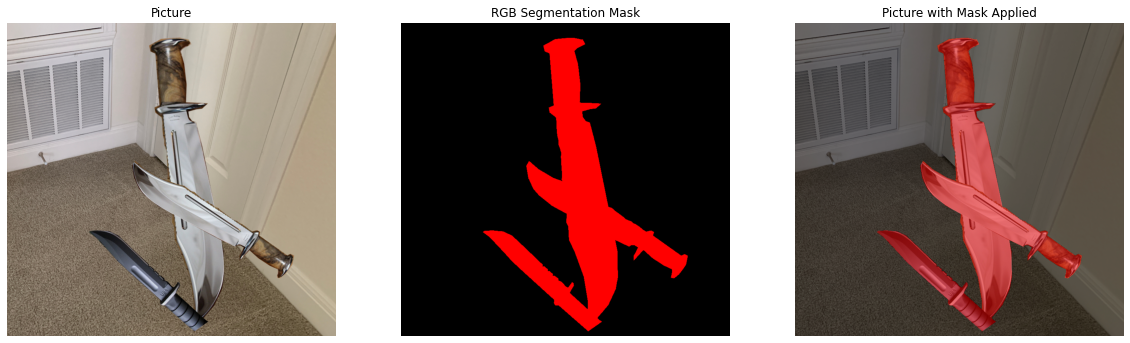

In [7]:
img_path = os.path.join(images_path, common_filenames[1])
image = Image.open(img_path)
mask_path = os.path.join(seg_masks_path, common_filenames[1])
mask = Image.open(mask_path)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture')
ax1.set_axis_off()

ax2.imshow(mask)
ax2.set_title('RGB Segmentation Mask')
ax2.set_axis_off()

ax3.imshow(image)
ax3.imshow(mask, alpha=0.5)
ax3.set_title('Picture with Mask Applied')
ax3.set_axis_off()

In [8]:
class GunsBoxesDataset(Dataset):
    '''
    Pytorch Dataset class for creating training and validation dataset from images and masks
    '''
    def __init__(self, img_dir, mask_dir, index, mean, std, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.index = index
        self.transform = transform
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.index)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.index[idx])
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        mask_path = os.path.join(self.mask_dir, self.index[idx])
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        return img, mask
    

In [9]:
# We normalize using Imagenet's mean and std for pretrained model
imagenet_mean=[0.485, 0.456, 0.406]
imagenet_std=[0.229, 0.224, 0.225]

# Params
Height = 704
Width = 1056 

# augmentations for training and validation
train_augmentation = A.Compose([A.Resize(Height, Width, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), 
                     A.VerticalFlip(), A.GridDistortion(p=0.2), 
                     A.RandomBrightnessContrast((0,0.5),(0,0.5)), A.GaussNoise()])

val_augmentation = A.Compose([A.Resize(Height, Width, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

# creating datasets
train_set = GunsBoxesDataset(images_path, class_masks_path, X_train, imagenet_mean, imagenet_std, train_augmentation)
val_set = GunsBoxesDataset(images_path, class_masks_path, X_val, imagenet_mean, imagenet_std, val_augmentation)

# dataloader
batch_size= 3 
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               

##### Download Pre-trained U-Net model

In [10]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=3, \
                 activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

##### Create metrics for Semantic Segmentation

In [11]:
def pixel_accuracy(output, mask):
    '''
    Pixel Accuracy is the percent of pixels in your image that are classified correctly.
    '''
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        pixel_accuracy = float(correct.sum()) / float(correct.numel())
    return pixel_accuracy

In [12]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=3):
    '''
    IoU is the area of overlap between the predicted segmentation and the ground truth divided
    by the area of union between the predicted segmentation and the ground truth.
    mIoU is the mean for IoU for all classes.
    '''
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

##### Model training

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
def get_lr(optimizer):
    '''Returns the learning rate of optimizer'''
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler):
    torch.cuda.empty_cache()
    
    # Loss
    train_losses = []
    test_losses = []
    
    # Metrics
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    # Send Model to Device
    model.to(device)
    fit_time = time.time()
    
    for epoch in range(epochs):
        since = time.time()
        
        running_loss = 0
        iou_score = 0
        accuracy = 0
        
        #training mode
        model.train()
        
        for i, data in enumerate(tqdm(train_loader)):
            image, mask = data
            image = image.to(device)
            mask = mask.to(device)
            
            # forward pass
            output = model(image)
            loss = criterion(output, mask)
            
            # evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            
            # backward pass
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            
            # Evaluation mode
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    image, mask = data
                    image = image.to(device); 
                    mask = mask.to(device);
                    output = model(image)
                    
                    # evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    
                    # loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))
            
            # Checkpoint - Save Model if loss is decreasing after every 2 epochs
            if(min_loss > (test_loss/len(val_loader))):
               print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
               min_loss = (test_loss/len(val_loader))
               decrease += 1
               if decrease % 2 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
   
            # Stop training if loss is not decreasing after 5 epochs
            if ((test_loss/len(val_loader)) > min_loss):
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 5:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
               
                        
            # mIOU
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            
            # pixel accuracy
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            
            # Print Epoch Details
            print("Epoch:{}/{}..".format(epoch+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [15]:
max_lr = 1e-3
epoch = 12
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.253 
saving model...
Epoch:1/12.. Train Loss: 0.601.. Val Loss: 0.253.. Train mIoU:0.513.. Val mIoU: 0.732.. Train Acc:0.809.. Val Acc:0.955.. Time: 2.88m


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss Decreasing.. 0.253 >> 0.204 
Epoch:2/12.. Train Loss: 0.202.. Val Loss: 0.204.. Train mIoU:0.698.. Val mIoU: 0.670.. Train Acc:0.946.. Val Acc:0.922.. Time: 2.86m


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss Decreasing.. 0.204 >> 0.162 
saving model...
Epoch:3/12.. Train Loss: 0.185.. Val Loss: 0.162.. Train mIoU:0.681.. Val mIoU: 0.613.. Train Acc:0.942.. Val Acc:0.943.. Time: 2.93m


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:4/12.. Train Loss: 0.166.. Val Loss: 0.171.. Train mIoU:0.710.. Val mIoU: 0.735.. Train Acc:0.948.. Val Acc:0.938.. Time: 2.89m


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss Decreasing.. 0.171 >> 0.149 
Epoch:5/12.. Train Loss: 0.147.. Val Loss: 0.149.. Train mIoU:0.747.. Val mIoU: 0.694.. Train Acc:0.956.. Val Acc:0.947.. Time: 2.85m


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss Decreasing.. 0.149 >> 0.115 
saving model...
Epoch:6/12.. Train Loss: 0.131.. Val Loss: 0.115.. Train mIoU:0.775.. Val mIoU: 0.792.. Train Acc:0.961.. Val Acc:0.966.. Time: 2.95m


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss Decreasing.. 0.115 >> 0.100 
Epoch:7/12.. Train Loss: 0.125.. Val Loss: 0.100.. Train mIoU:0.782.. Val mIoU: 0.824.. Train Acc:0.965.. Val Acc:0.971.. Time: 2.94m


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss Decreasing.. 0.100 >> 0.083 
saving model...
Epoch:8/12.. Train Loss: 0.104.. Val Loss: 0.083.. Train mIoU:0.823.. Val mIoU: 0.849.. Train Acc:0.971.. Val Acc:0.974.. Time: 2.88m


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:9/12.. Train Loss: 0.095.. Val Loss: 0.083.. Train mIoU:0.834.. Val mIoU: 0.839.. Train Acc:0.973.. Val Acc:0.976.. Time: 2.89m


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss Decreasing.. 0.083 >> 0.076 
Epoch:10/12.. Train Loss: 0.085.. Val Loss: 0.076.. Train mIoU:0.851.. Val mIoU: 0.839.. Train Acc:0.976.. Val Acc:0.978.. Time: 2.86m


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss Decreasing.. 0.076 >> 0.073 
saving model...
Epoch:11/12.. Train Loss: 0.082.. Val Loss: 0.073.. Train mIoU:0.862.. Val mIoU: 0.854.. Train Acc:0.977.. Val Acc:0.977.. Time: 2.97m


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:12/12.. Train Loss: 0.076.. Val Loss: 0.075.. Train mIoU:0.868.. Val mIoU: 0.873.. Train Acc:0.978.. Val Acc:0.977.. Time: 2.96m
Total time: 34.86 m


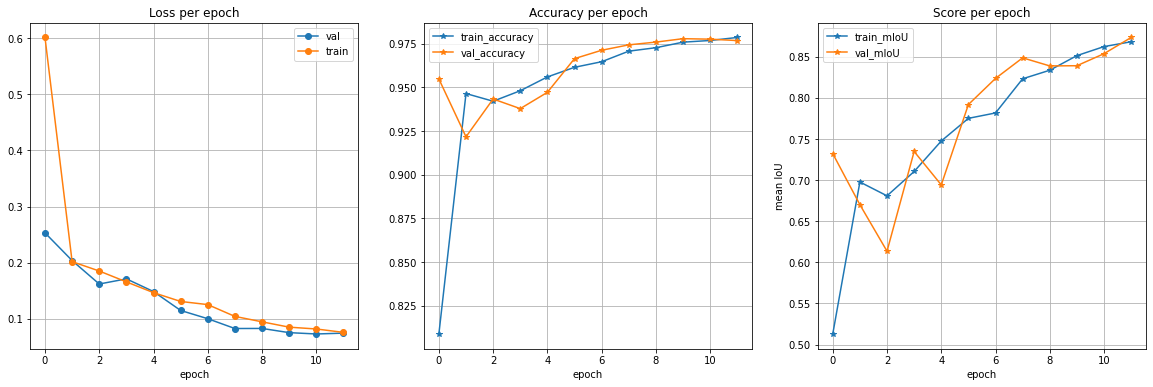

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,6))

# Loss
def plot_loss(history, ax):
    ax.plot(history['val_loss'], label='val', marker='o')
    ax.plot( history['train_loss'], label='train', marker='o')
    ax.set_title('Loss per epoch'); plt.ylabel('loss');
    ax.set_xlabel('epoch')
    ax.legend(), ax.grid()
    #plt.show()

# Accuracy   
def plot_acc(history, ax):
    ax.plot(history['train_acc'], label='train_accuracy', marker='*')
    ax.plot(history['val_acc'], label='val_accuracy',  marker='*')
    ax.set_title('Accuracy per epoch'); plt.ylabel('Accuracy')
    ax.set_xlabel('epoch')
    ax.legend(), ax.grid()
    #plt.show()

# Score
def plot_score(history, ax):
    ax.plot(history['train_miou'], label='train_mIoU', marker='*')
    ax.plot(history['val_miou'], label='val_mIoU',  marker='*')
    ax.set_title('Score per epoch'); plt.ylabel('mean IoU')
    ax.set_xlabel('epoch')
    ax.legend(), ax.grid()
    #ax.show()

plot_loss(history, ax1)
plot_acc(history, ax2)
plot_score(history, ax3)

##### Create Test Dataset

In [17]:
class GunsBoxesTestDataset(Dataset):
    '''
    Pytorch Dataset class for creating test dataset from images and masks
    '''
    def __init__(self, img_dir, mask_dir, index, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.index = index
        self.transform = transform
        
    def __len__(self):
        return len(self.index)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.index[idx])
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        mask_path = os.path.join(self.mask_dir, self.index[idx])
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
            
        mask = torch.from_numpy(mask).long()
        return img, mask
    

In [18]:
test_augmentation = A.Resize(Height, Width, interpolation=cv2.INTER_NEAREST)
test_set = GunsBoxesTestDataset(images_path, class_masks_path, X_test, test_augmentation)

##### Predictions

In [19]:
def predict_image_mask_miou(model, image, mask, mean=imagenet_mean, std=imagenet_std):
    '''
    Returns Predicted Mask and mIOU
    '''
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

def predict_image_mask_pixel(model, image, mask, mean=imagenet_mean, std=imagenet_std):
    '''
    Returns Predicted Mask and pixel accuracy
    '''
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

def miou_score(model, test_set):
    '''Calculate mIOU for Test Dataset'''
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

def pixel_acc(model, test_set):
    '''Calculate pixel accuracy for Test Dataset'''
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

##### Example Predictions

Test Picture 1

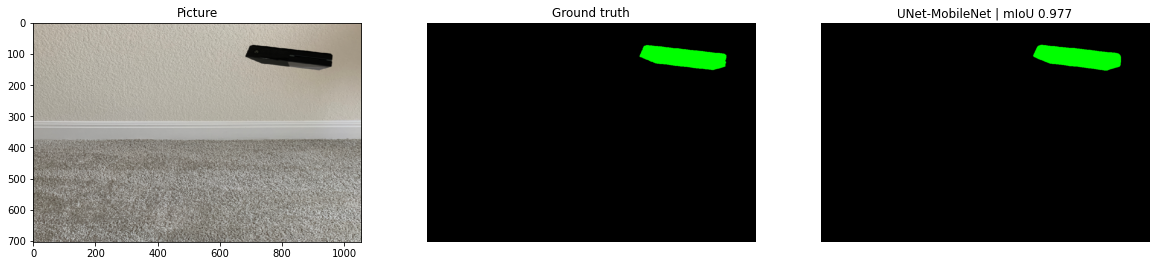

In [28]:
image1, mask1 = test_set[2]
pred_mask1, score1 = predict_image_mask_miou(model, image1, mask1)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image1)
ax1.set_title('Picture');

ax2.imshow(class_mask_to_segmentation_mask(mask1))
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(class_mask_to_segmentation_mask(pred_mask1))
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score1))
ax3.set_axis_off()

Test Picture 2

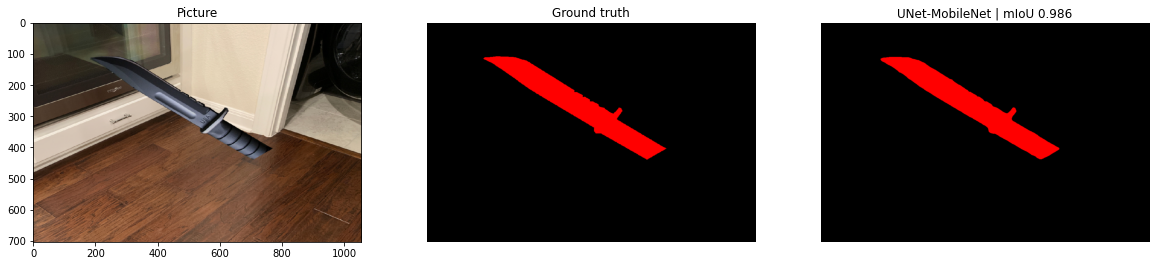

In [29]:
image2, mask2 = test_set[11]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(class_mask_to_segmentation_mask(mask2))
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(class_mask_to_segmentation_mask(pred_mask2))
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

Test Picture 3

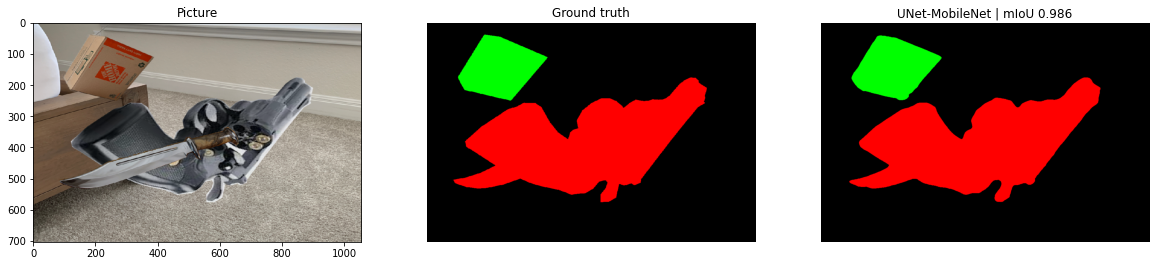

In [27]:
image3, mask3 = test_set[22]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(class_mask_to_segmentation_mask(mask3))
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(class_mask_to_segmentation_mask(pred_mask3))
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

##### Final Results

In [23]:
mob_miou = miou_score(model, test_set)
mob_acc = pixel_acc(model, test_set)

print('Test Set mIoU', np.mean(mob_miou))
print('Test Set Pixel Accuracy', np.mean(mob_acc))

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Test Set mIoU 0.8895406810807573
Test Set Pixel Accuracy 0.9766919084629269


#### References

1. https://www.kaggle.com/bulentsiyah/deep-learning-based-semantic-segmentation-keras
2. https://www.kaggle.com/ligtfeather/semantic-segmentation-is-easy-with-pytorch
3. https://www.kaggle.com/bulentsiyah/preprocessing-rgb-img-masks-to-segmentation-masks
4. https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2